# Cat Tree Reviews to Images

### Import libraries

In [37]:
!pip install sentence-transformers faiss-cpu scikit-learn -q

In [38]:
!pip install scikit-learn matplotlib seaborn -q

In [39]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
import faiss
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import openai

## Part 1 - Preprocessing Reviews

In [40]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [41]:
csv_path = '/content/drive/MyDrive/CMU课件/Gen AI Lab/cat_tree_reviews.csv'
df = pd.read_csv(csv_path)

In [42]:
df

,f7,f7 2,b,flex,flex 2,b 2,mv1,b 3,mv1 2,w_iUH7,b 4,tl-m,ml1,w_kV33
0,"Jul 13, 2025",Janie,Item details,Color: Dark Gray,Assembled product height: 54 in,Sold by,"Factory Direct Wholesales, LLC",Delivered by,Walmart,5 out of 5 stars review,Verified Purchase,The Best Pet Tower has been a blessing to my t...,(0),NaN
1,"Oct 7, 2025",MattM,Item details,Color: Dark Gray,Assembled product height: 54 in,Sold by,"Factory Direct Wholesales, LLC",Delivered by,Walmart,5 out of 5 stars review,Verified Purchase,I found the assembly process quite enjoyable. ...,(0),NaN
2,"Oct 12, 2025",Chasidy,Item details,Color: Dark Gray,Assembled product height: 54 in,Sold and shipped by,"Factory Direct Wholesales, LLC",NaN,NaN,5 out of 5 stars review,Verified Purchase,it's a lot smaller than I thought it would be ...,(0),smaller cats or kittens for sure who know larg...
3,"Sep 22, 2025",Kittyfood,Item details,Color: Dark Gray,Assembled product height: 54 in,Sold by,"Factory Direct Wholesales, LLC",Delivered by,Walmart,5 out of 5 stars review,Verified Purchase,Yes ordering online and having it shipped to y...,(0),NaN
4,"Oct 6, 2025",Katrina,Item details,Color: Pink,"Assembled product height: 56""",Sold and shipped by,"Factory Direct Wholesales, LLC",NaN,NaN,3 out of 5 stars review,Verified Purchase,I ordered the 56 inch activity house. My cat i...,(0),Too small for AVERAGE cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,"Aug 28, 2023",Candice,NaN,NaN,NaN,Sold by,"Factory Direct Wholesales, LLC",NaN,NaN,5 out of 5 stars review,Verified Purchase,I Love it my cats love it,(0),Five stars
737,"Apr 25, 2023",Britt,Verified Purchase,NaN,NaN,NaN,NaN,NaN,NaN,5 out of 5 stars review,NaN,"Very strong , tall and my cat loves it worth i...",(0),Will buy again !
738,"Dec 23, 2023",Mia,NaN,NaN,NaN,Sold by,"Factory Direct Wholesales, LLC",NaN,NaN,3 out of 5 stars review,Verified Purchase,It was for a large/Big cat. It should have bee...,(0),Live n learn
739,"Nov 7, 2023",susan,NaN,NaN,NaN,Sold by,"Factory Direct Wholesales, LLC",NaN,NaN,5 out of 5 stars review,Verified Purchase,Made very well and easy to put together. Very ...,(0),NaN


In [43]:
# Extract and clean reviews column
df_reviews = df[['tl-m']].copy()

# Remove rows with NaN values
df_reviews = df_reviews.dropna()

# Rename column to 'review'
df_reviews = df_reviews.rename(columns={'tl-m': 'review'})

# Reset index after dropping NaN
df_reviews = df_reviews.reset_index(drop=True)

df_reviews

,review
0,The Best Pet Tower has been a blessing to my t...
1,I found the assembly process quite enjoyable. ...
2,it's a lot smaller than I thought it would be ...
3,Yes ordering online and having it shipped to y...
4,I ordered the 56 inch activity house. My cat i...
...,...
725,I Love it my cats love it
726,"Very strong , tall and my cat loves it worth i..."
727,It was for a large/Big cat. It should have bee...
728,Made very well and easy to put together. Very ...


In [44]:
# Save cleaned data
output_path = '/content/drive/MyDrive/CMU课件/Gen AI Lab/cat_tree_reviews_cleaned.csv'
df_reviews[['review']].to_csv(output_path, index=False)
print(f"\nCleaned reviews saved to: {output_path}")


Cleaned reviews saved to: /content/drive/MyDrive/CMU课件/Gen AI Lab/cat_tree_reviews_cleaned.csv


## Part 2 - LLM Analysis of Reviews

### Combine all reviews

In [45]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [46]:
csv_path = '/content/drive/MyDrive/CMU课件/Gen AI Lab/cat_tree_reviews_cleaned.csv'
df_reviews = pd.read_csv(csv_path)

In [47]:
df_reviews

,review
0,The Best Pet Tower has been a blessing to my t...
1,I found the assembly process quite enjoyable. ...
2,it's a lot smaller than I thought it would be ...
3,Yes ordering online and having it shipped to y...
4,I ordered the 56 inch activity house. My cat i...
...,...
725,I Love it my cats love it
726,"Very strong , tall and my cat loves it worth i..."
727,It was for a large/Big cat. It should have bee...
728,Made very well and easy to put together. Very ...


In [48]:
# Combine all reviews into one large text corpus
all_reviews_text = "\n\n---REVIEW---\n\n".join(df_reviews['review'].tolist())

print(f"Total reviews: {len(df_reviews)}")
print(f"Combined text length: {len(all_reviews_text)} characters")
print(f"Estimated tokens: ~{len(all_reviews_text) // 4}")  # Rough estimate: 1 token ≈ 4 chars

# Preview combined text
print("\n--- First 500 characters of combined reviews ---")
print(all_reviews_text[:500])

Total reviews: 730
Combined text length: 114899 characters
Estimated tokens: ~28724

--- First 500 characters of combined reviews ---
The Best Pet Tower has been a blessing to my two cats.  They love it but are too big for some of the smaller pet houses. The tower is adjustable as  took off the smaller pet houses and replaced them with the larger benches.  Great product that makes my cats me-wow!

---REVIEW---

I found the assembly process quite enjoyable. Everything was very compact in the box for the size of the finished product.  My cat loves it despite being over 10 and less active than he used to be. At first, he ignored 


### Visualization - Embedding & Clustering Analysis

In [49]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_reviews['review'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

In [50]:
# KMeans clustering
from sklearn.cluster import KMeans
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Add cluster column to dataframe
df_reviews['cluster'] = cluster_labels

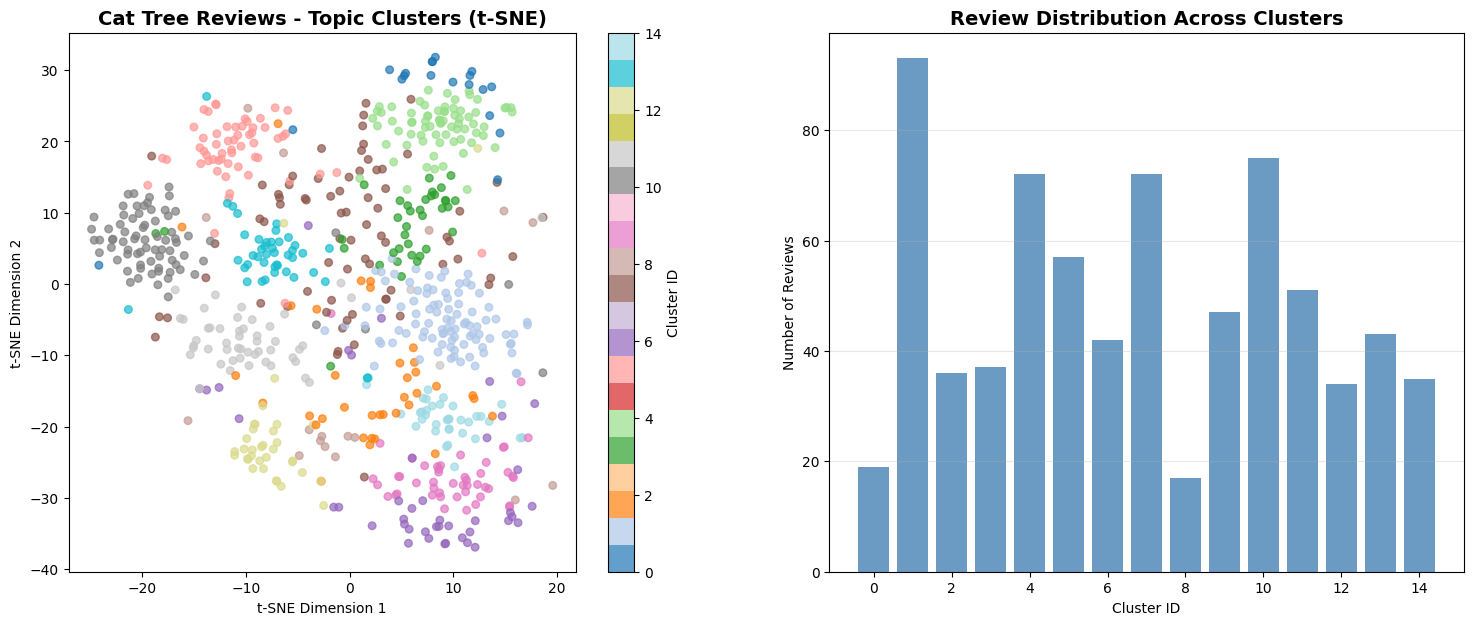

In [51]:
# PART 1: Visualization - Embedding & Clustering Analysis

# Visualize clusters using t-SNE (2D projection)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Cluster distribution
scatter = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=df_reviews['cluster'], cmap='tab20', alpha=0.7, s=30)
axes[0].set_title('Cat Tree Reviews - Topic Clusters (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, ax=axes[0], label='Cluster ID')

# Plot 2: Cluster size distribution
cluster_counts = df_reviews['cluster'].value_counts().sort_index()
axes[1].bar(cluster_counts.index, cluster_counts.values, color='steelblue', alpha=0.8)
axes[1].set_title('Review Distribution Across Clusters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Number of Reviews')
axes[1].grid(axis='y', alpha=0.3)


In [52]:
# Extract and display sample reviews from each cluster (topic analysis)
print("CLUSTER TOPIC ANALYSIS")

cluster_topics = {}
for cluster_id in range(n_clusters):
    cluster_reviews = df_reviews[df_reviews['cluster'] == cluster_id]
    # Get a representative sample
    sample_review = cluster_reviews['review'].iloc[0]
    cluster_topics[cluster_id] = {
        'count': len(cluster_reviews),
        'sample': sample_review[:150] + "..." if len(sample_review) > 150 else sample_review
    }
    print(f"\nCluster {cluster_id} ({cluster_topics[cluster_id]['count']} reviews):")
    print(f"  Sample: {cluster_topics[cluster_id]['sample']}")

CLUSTER TOPIC ANALYSIS

Cluster 0 (19 reviews):
  Sample: My fur baby circled around it for several days…took hidden treats to get her on it-guess she is still adjusting to the change.

Cluster 1 (93 reviews):
  Sample: I found the assembly process quite enjoyable. Everything was very compact in the box for the size of the finished product.  My cat loves it despite be...

Cluster 2 (36 reviews):
  Sample: I love it!! Super easy to assemble and simple instructions! It came really fast and my cats are playing with it immediately! I wish I had more space t...

Cluster 3 (37 reviews):
  Sample: The flash sale price was amazing, the size after putting together was not what I was expecting. The platforms are very small and they have a lot of mo...

Cluster 4 (72 reviews):
  Sample: Now that my cat has had more time... she absolutely loves it! My husband sprinkled a bit of cat nip from Shady Cat in each box and finally she took to...

Cluster 5 (57 reviews):
  Sample: it's a lot smaller than 

### OpenAI API analysis

In [53]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
print("OpenAI API key loaded")

from openai import OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

OpenAI API key loaded


In [54]:
# Prepare the analysis prompt
# Prompt 1
analysis_prompt = f"""You are an expert product analyst. Analyze the following {len(df_reviews)} customer reviews for a BestPet 70in Cat Tree Tower (Dark Gray).

Your task is to extract VISUAL and STRUCTURAL information useful for generating product images. Focus on:

1. **Structure & Dimensions**: Height, number of levels/tiers, platform arrangement, base design
2. **Materials & Textures**: Fabric types (plush, carpet, sisal), surface textures
3. **Key Components**: Scratching posts, cat houses/condos, perches, ladders, hammocks
4. **Design Elements**: Hanging toys, pom-poms, color schemes, platform shapes
5. **Overall Aesthetic**: Sturdy/wobbly, compact/spacious style

Provide a JSON output with this structure:
{{
  "structure": {{
    "height": "description",
    "tiers": "number and arrangement",
    "base": "stability and design"
  }},
  "materials": {{
    "primary_covering": "material type",
    "textures": ["list of textures mentioned"],
    "quality": "overall quality perception"
  }},
  "components": {{
    "scratching_posts": "description",
    "enclosed_spaces": "cat houses/condos details",
    "platforms": "types and sizes",
    "toys": "hanging toys, balls, etc."
  }},
  "colors": {{
    "primary": "main color",
    "accents": ["additional colors"]
  }},
  "keywords": ["descriptive adjectives from reviews"],
  "image_prompt": "A comprehensive prompt for image generation based on all extracted features"
}}

CUSTOMER REVIEWS:
---
{all_reviews_text}
---

Provide ONLY valid JSON output, no additional text or markdown.
"""

# Call OpenAI API

try:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert product analyst. Output only valid JSON."},
            {"role": "user", "content": analysis_prompt}
        ],
        temperature=0.3,
        max_tokens=2000
    )

    llm_output = response.choices[0].message.content
    print("Response received!\n")

    # Clean and parse JSON
    # Remove markdown code blocks if present
    llm_output_clean = llm_output.strip()
    if llm_output_clean.startswith("```"):
        llm_output_clean = llm_output_clean.split("```")[1]
        if llm_output_clean.startswith("json"):
            llm_output_clean = llm_output_clean[4:]
    llm_output_clean = llm_output_clean.strip()

    # Parse JSON
    extracted_features = json.loads(llm_output_clean)

    # Display results
    print("EXTRACTED VISUAL FEATURES")
    print(json.dumps(extracted_features, indent=2))

    # Save to file
    output_path = '/content/drive/MyDrive/CMU课件/Gen AI Lab/cat_tree_extracted_features.json'
    with open(output_path, 'w') as f:
        json.dump(extracted_features, f, indent=2)
    print(f"Features saved to: {output_path}")

    # Display the image generation prompt
    print("FINAL IMAGE GENERATION PROMPT")
    print(extracted_features.get('image_prompt', 'N/A'))

except Exception as e:
    print(f"Error: {str(e)}")

Response received!

EXTRACTED VISUAL FEATURES
{
  "structure": {
    "height": "70 inches",
    "tiers": "multiple levels, compact arrangement",
    "base": "stability issues, compact design"
  },
  "materials": {
    "primary_covering": "plush fabric",
    "textures": [
      "soft",
      "fuzzy",
      "plush"
    ],
    "quality": "mixed reviews, some perceive as low quality"
  },
  "components": {
    "scratching_posts": "sisal rope, some reviews mention insufficient quantity",
    "enclosed_spaces": "small cat houses/condos, not suitable for larger cats",
    "platforms": "small platforms, not suitable for large cats",
    "toys": "hanging toys, pom-poms, easily detachable"
  },
  "colors": {
    "primary": "dark gray",
    "accents": [
      "navy blue",
      "light gray"
    ]
  },
  "keywords": [
    "compact",
    "wobbly",
    "affordable",
    "soft",
    "small",
    "easy assembly",
    "unstable",
    "cute",
    "cheap",
    "sturdy"
  ],
  "image_prompt": "A tall, dar

In [55]:
# Improve prompt to only retain positive features
# Prompt 2
improved_prompt = f"""Analyze these {len(df_reviews)} customer reviews for a cat tree tower.

Extract TWO separate outputs:

1. **POSITIVE VISUAL FEATURES**: Physical features mentioned in POSITIVE reviews (4-5 stars)
   - Structure, materials, components that customers LIKED

2. **NEGATIVE VISUAL FEATURES**: Issues mentioned in NEGATIVE reviews (1-3 stars)
   - Problems like size, stability, quality concerns

3. **IDEAL_IMAGE_PROMPT**: Based ONLY on positive features, create an image generation prompt that represents the product at its best.

4. **REALISTIC_IMAGE_PROMPT**: A balanced prompt reflecting both positive aspects and common complaints.

Output JSON format:
{{
  "positive_features": {{...}},
  "negative_features": {{...}},
  "ideal_image_prompt": "prompt focusing on best features",
  "realistic_image_prompt": "balanced prompt"
}}

REVIEWS:
{all_reviews_text}
"""

# Call OpenAI API

try:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert product analyst. Output only valid JSON."},
            {"role": "user", "content": analysis_prompt}
        ],
        temperature=0.3,
        max_tokens=2000
    )

    llm_output = response.choices[0].message.content
    print("Response received!\n")

    # Clean and parse JSON
    # Remove markdown code blocks if present
    llm_output_clean = llm_output.strip()
    if llm_output_clean.startswith("```"):
        llm_output_clean = llm_output_clean.split("```")[1]
        if llm_output_clean.startswith("json"):
            llm_output_clean = llm_output_clean[4:]
    llm_output_clean = llm_output_clean.strip()

    # Parse JSON
    extracted_features = json.loads(llm_output_clean)

    # Display results
    print("EXTRACTED VISUAL FEATURES")
    print(json.dumps(extracted_features, indent=2))

    # Save to file
    output_path = '/content/drive/MyDrive/CMU课件/Gen AI Lab/cat_tree_extracted_positive_features.json'
    with open(output_path, 'w') as f:
        json.dump(extracted_features, f, indent=2)
    print(f"Features saved to: {output_path}")

    # Display the image generation prompt
    print("FINAL IMAGE GENERATION PROMPT")
    print(extracted_features.get('image_prompt', 'N/A'))

except Exception as e:
    print(f"Error: {str(e)}")

Response received!

EXTRACTED VISUAL FEATURES
{
  "structure": {
    "height": "70 inches",
    "tiers": "multiple levels with compact arrangement",
    "base": "stability issues, often described as wobbly"
  },
  "materials": {
    "primary_covering": "plush fabric",
    "textures": [
      "soft",
      "fuzzy",
      "plush"
    ],
    "quality": "perceived as low quality, prone to shedding and instability"
  },
  "components": {
    "scratching_posts": "limited number, often described as too small",
    "enclosed_spaces": "small cat houses/condos, not suitable for larger cats",
    "platforms": "small and compact, not suitable for larger cats",
    "toys": "hanging balls, often detached easily"
  },
  "colors": {
    "primary": "dark gray",
    "accents": [
      "navy blue",
      "light gray"
    ]
  },
  "keywords": [
    "compact",
    "wobbly",
    "small",
    "soft",
    "affordable",
    "unstable",
    "easy assembly",
    "cheap"
  ],
  "image_prompt": "A 70-inch tall dar

In [56]:
# Manually reduce negative words in the prompt
# Prompt 3
ideal_prompt = """
A 70-inch tall multi-tiered cat tree tower in dark gray plush fabric,
featuring 5-6 spacious platforms at different heights,
sisal-wrapped scratching posts,
two cozy enclosed cat condos with circular entrances,
soft carpeted perches,
hanging pom-pom toys,
sturdy wide base for stability,
set against a clean white background,
product photography style,
high quality, detailed textures
"""

## Part 3 - Image Generation

### 3 prompts

In [57]:
import requests
import base64
from PIL import Image
from io import BytesIO

In [58]:
# Create output folder
output_folder = '/content/drive/MyDrive/CMU课件/Gen AI Lab/generated_images'
os.makedirs(output_folder, exist_ok=True)

In [59]:
# 3 prompts from Part B
prompts = {
    "review_based": """A 70-inch dark gray cat tree tower with multiple compact tiers. It features small platforms and enclosed spaces, covered in soft plush fabric. The base is not very stable, and the structure includes limited sisal scratching posts. Hanging toys like balls are attached but easily detachable. The overall aesthetic is compact and affordable, suitable for small cats or kittens.""",

    "positive_extracted": """A tall, dark gray cat tree tower with multiple compact levels and small platforms. It features plush fabric covering with a soft texture. The structure includes small enclosed cat houses and a few low-placed scratching posts. Hanging toys like balls are attached but appear easily detachable. The overall design looks wobbly and is more suitable for kittens or small cats. The color scheme is primarily dark gray with some navy blue and light gray accents.""",

    "ideal_manual": """A 70-inch tall multi-tiered cat tree tower in dark gray plush fabric, featuring 5-6 spacious platforms at different heights, sisal-wrapped scratching posts, two cozy enclosed cat condos with circular entrances, soft carpeted perches, hanging pom-pom toys, sturdy wide base for stability, set against a clean white background, product photography style, high quality, detailed textures"""
}

### DALL-E

In [71]:
dalle_images = {}

for prompt_name, prompt_text in prompts.items():
    print(f"\nGenerating: {prompt_name}...")

    try:
        response = client.images.generate(
            model="dall-e-3",
            prompt=prompt_text,
            size="1024x1024",
            quality="standard",
            n=1
        )

        image_url = response.data[0].url
        dalle_images[prompt_name] = image_url

        # Download and save image
        img_response = requests.get(image_url)
        img = Image.open(BytesIO(img_response.content))
        save_path = f"{output_folder}/dalle3_{prompt_name}.png"
        img.save(save_path)

        print(f"Saved: dalle3_{prompt_name}.png")

    except Exception as e:
        print(f"Error: {str(e)}")



Generating: review_based...
Saved: dalle3_review_based.png

Generating: positive_extracted...
Saved: dalle3_positive_extracted.png

Generating: ideal_manual...
Saved: dalle3_ideal_manual.png



--- DALL-E 3 Results ---


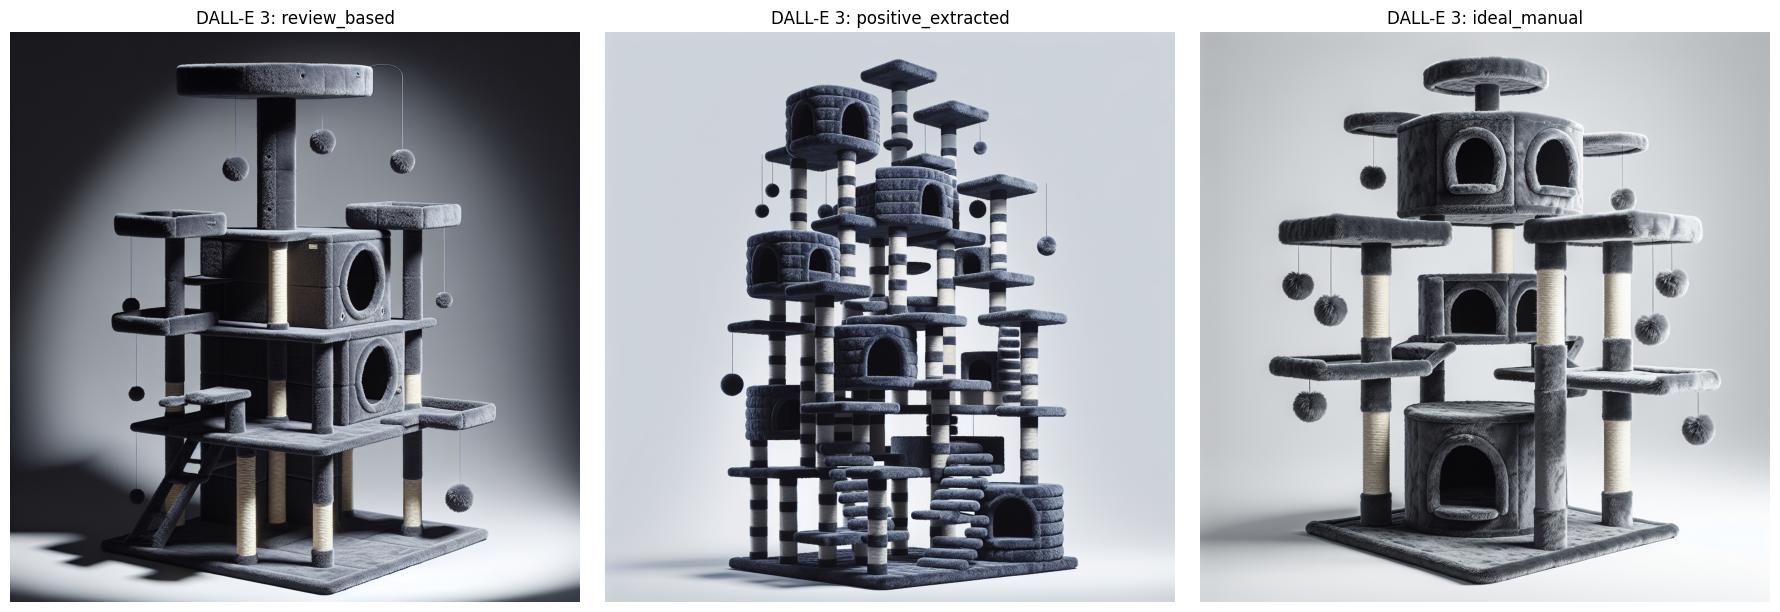

In [72]:
# Display DALL-E images
print("\n--- DALL-E 3 Results ---")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for idx, (prompt_name, _) in enumerate(prompts.items()):
    img_path = f"{output_folder}/dalle3_{prompt_name}.png"
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"DALL-E 3: {prompt_name}", fontsize=12)
        axes[idx].axis('off')
plt.tight_layout()
plt.savefig(f"{output_folder}/dalle3_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

### Stable Diffusion


Generating: review_based...
Saved: sd_review_based.png

Generating: positive_extracted...
Saved: sd_positive_extracted.png

Generating: ideal_manual...
Saved: sd_ideal_manual.png

--- Stable Diffusion Results ---


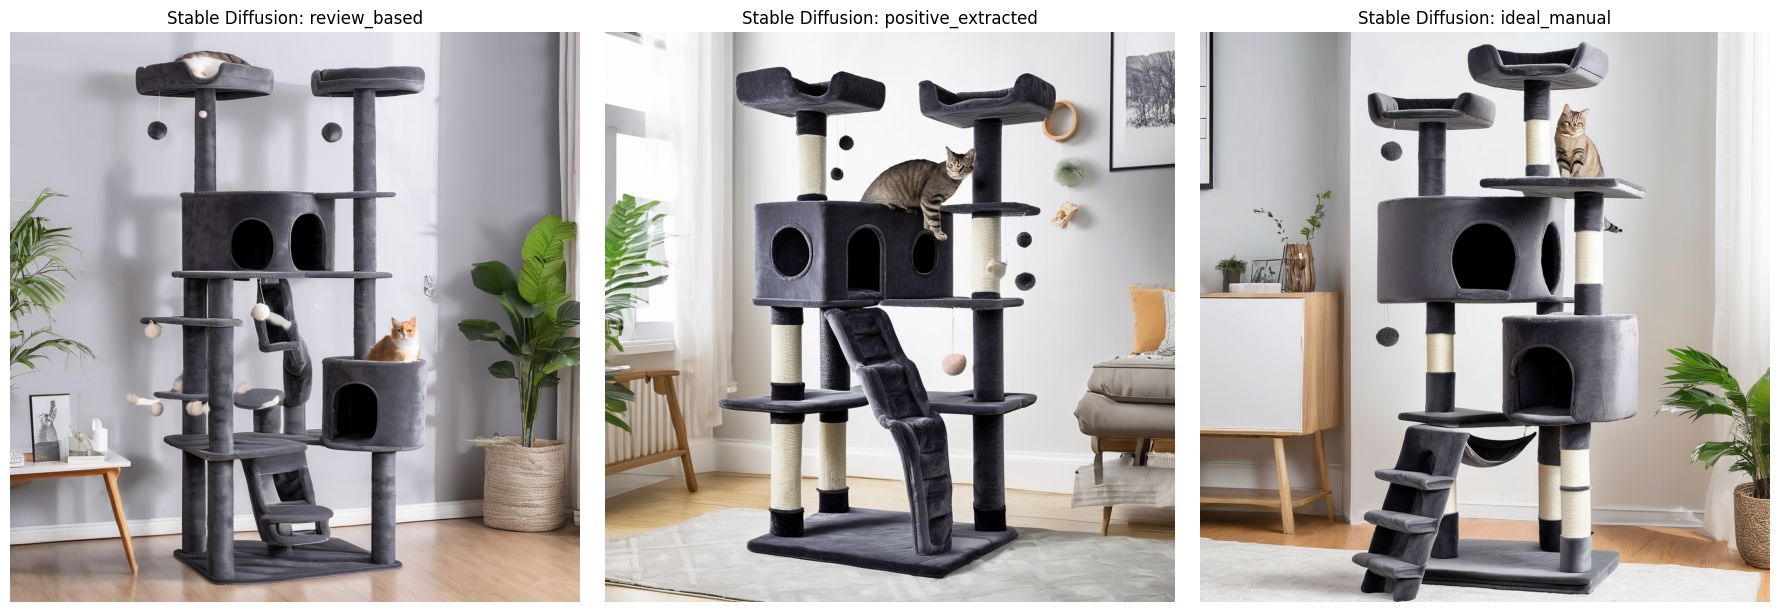

In [66]:
try:
    STABILITY_API_KEY = userdata.get('STABILITY_API_KEY')

    sd_images = {}

    for prompt_name, prompt_text in prompts.items():
        print(f"\nGenerating: {prompt_name}...")

        response = requests.post(
            "https://api.stability.ai/v1/generation/stable-diffusion-xl-1024-v1-0/text-to-image",
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {STABILITY_API_KEY}"
            },
            json={
                "text_prompts": [{"text": prompt_text, "weight": 1}],
                "cfg_scale": 7,
                "height": 1024,
                "width": 1024,
                "samples": 1,
                "steps": 30
            }
        )

        if response.status_code == 200:
            data = response.json()
            img_data = base64.b64decode(data["artifacts"][0]["base64"])
            img = Image.open(BytesIO(img_data))
            save_path = f"{output_folder}/sd_{prompt_name}.png"
            img.save(save_path)
            sd_images[prompt_name] = save_path
            print(f"Saved: sd_{prompt_name}.png")
        else:
            print(f"Error: {response.status_code} - {response.text}")

    # Display SD images
    print("\n--- Stable Diffusion Results ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for idx, (prompt_name, _) in enumerate(prompts.items()):
        img_path = f"{output_folder}/sd_{prompt_name}.png"
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"Stable Diffusion: {prompt_name}", fontsize=12)
            axes[idx].axis('off')
    plt.tight_layout()
    plt.savefig(f"{output_folder}/sd_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"{str(e)}")